In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data/traveler-conversion.csv',sep=',')

In [3]:
df.head(5)

,visitorId,timeOnSite,numPDPViews,numUniquePDPViews,numPDPFavorited,numSearchesCompleted,completedDatedSearch,numUniqueDatedSearchesCompleted,enteredNumGuests,performedCustomSort,appliedAnyFilter,appliedPriceFilter,searchedBookItNow,searchedInstantBook,inquired,sentBookingRequest
0,5.922358e+18,0.320883,1,1,0,0,False,0,False,False,False,False,False,False,False,False
1,7.812656e+18,111.626495,1,1,0,1,True,1,False,False,False,False,False,False,False,False
2,9.183575e+18,179.577403,1,1,0,1,True,1,False,False,False,False,False,False,False,False
3,4.226089e+18,0.203085,0,0,0,0,False,0,False,False,False,False,False,False,False,False
4,4.006937e+18,7.169975,1,1,0,0,False,0,False,False,False,False,False,False,False,False


In [4]:
cat_cols = ['completedDatedSearch','enteredNumGuests','performedCustomSort','appliedAnyFilter','appliedPriceFilter',\
           'searchedBookItNow','searchedInstantBook','inquired','sentBookingRequest']

In [5]:
for c in range(0,len(cat_cols)):
    print cat_cols[c]
    new = df[cat_cols[c]].astype(int)
    df[cat_cols[c]] = new

completedDatedSearch
enteredNumGuests
performedCustomSort
appliedAnyFilter
appliedPriceFilter
searchedBookItNow
searchedInstantBook
inquired
sentBookingRequest


In [6]:
np.random.seed(200)
train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [7]:
train_X = train.ix[:,1:15]
train_Y = train.ix[:,15]

In [8]:
pd.DataFrame.corr(train)['sentBookingRequest']

visitorId                         -0.004545
timeOnSite                         0.125799
numPDPViews                        0.087515
numUniquePDPViews                  0.078225
numPDPFavorited                    0.027340
numSearchesCompleted               0.055905
completedDatedSearch               0.070433
numUniqueDatedSearchesCompleted    0.061142
enteredNumGuests                   0.232891
performedCustomSort                0.023665
appliedAnyFilter                   0.052268
appliedPriceFilter                 0.029172
searchedBookItNow                       NaN
searchedInstantBook                0.008316
inquired                           0.057079
sentBookingRequest                 1.000000
Name: sentBookingRequest, dtype: float64

In [9]:
train.searchedBookItNow.value_counts()

0    60000
Name: searchedBookItNow, dtype: int64

In [10]:
train = train.drop('searchedBookItNow',1)

In [11]:
from sklearn.metrics import roc_auc_score
for i in range(0,len(train_X.columns)):
    score = roc_auc_score(train_Y, train_X.ix[:,i])
    print 'AUC for %s: %.4f' % (train_X.columns[i],score) 

AUC for timeOnSite: 0.7050
AUC for numPDPViews: 0.6462
AUC for numUniquePDPViews: 0.6356
AUC for numPDPFavorited: 0.5120
AUC for numSearchesCompleted: 0.5862
AUC for completedDatedSearch: 0.5869
AUC for numUniqueDatedSearchesCompleted: 0.5895
AUC for enteredNumGuests: 0.6650
AUC for performedCustomSort: 0.5117
AUC for appliedAnyFilter: 0.5457
AUC for appliedPriceFilter: 0.5068
AUC for searchedBookItNow: 0.5000
AUC for searchedInstantBook: 0.5012
AUC for inquired: 0.5227


In [12]:
threshold_list = train.numPDPViews.describe()[3:9].tolist()
print threshold_list

[0.0, 0.0, 1.0, 2.0, 130.0]


In [13]:
validate_X = validate.ix[:,1:15]
validate_Y = validate.ix[:,15]
for t in range(0,len(threshold_list)):
    feature = validate[['numPDPViews','sentBookingRequest']]
    thres = threshold_list[t]
    predictBookingRequest = feature.numPDPViews.apply(lambda x: 1 if x >= thres else 0)
    feature = feature.assign(predictBookingRequest = predictBookingRequest).assign(correctPredictionHeuristic = lambda x: x.sentBookingRequest == predictBookingRequest)
    accuracy = np.sum(feature.correctPredictionHeuristic)/float(len(feature.correctPredictionHeuristic))
    print 'Accuracy is %s for Hueristic Model with threshold of %s' % (accuracy,thres)

Accuracy is 0.0303 for Hueristic Model with threshold of 0.0
Accuracy is 0.0303 for Hueristic Model with threshold of 0.0
Accuracy is 0.3717 for Hueristic Model with threshold of 1.0
Accuracy is 0.734 for Hueristic Model with threshold of 2.0
Accuracy is 0.9697 for Hueristic Model with threshold of 130.0


No I would not use this to predict booking request.

In [14]:
for t in range(0,len(threshold_list)):
    #del feature
    feature = validate[['numPDPViews','sentBookingRequest']]
    thres = threshold_list[t]
    predictBookingRequest = feature.numPDPViews.apply(lambda x: 1 if x >= thres else 0)
    feature = feature.assign(predictBookingRequest = predictBookingRequest).assign(correctPredictionHeuristic = lambda x: x.sentBookingRequest == predictBookingRequest)
  
    TP = len(feature.loc[(feature.sentBookingRequest == 1) & (feature.predictBookingRequest == 1),'sentBookingRequest'])
    TN = len(feature.loc[(feature.sentBookingRequest == 0) & (feature.predictBookingRequest == 0),'sentBookingRequest'])
    FP = len(feature.loc[(feature.sentBookingRequest == 0) & (feature.predictBookingRequest == 1),'sentBookingRequest'])
    FN = len(feature.loc[(feature.sentBookingRequest == 1) & (feature.predictBookingRequest == 0),'sentBookingRequest'])
    if ((TP + FP) > 0) & ((TP + FN) >0):
        precision = TP / float(TP + FP)
        recall = TP / float(TP + FN)
        f_score = 2*(precision*recall)/(precision + recall)
        print 'F_score is %.4f for Hueristic Model with threshold of %s' % (f_score,thres)
    else:
        print 'Unable to calculate precision and recall with threshold of %s' % (thres)

F_score is 0.0588 for Hueristic Model with threshold of 0.0
F_score is 0.0588 for Hueristic Model with threshold of 0.0
F_score is 0.0749 for Hueristic Model with threshold of 1.0
F_score is 0.1032 for Hueristic Model with threshold of 2.0
Unable to calculate precision and recall with threshold of 130.0


## 3. 

In [15]:
train_X = train_X.drop(['searchedBookItNow'],1)
train_X.columns

Index([u'timeOnSite', u'numPDPViews', u'numUniquePDPViews', u'numPDPFavorited',
       u'numSearchesCompleted', u'completedDatedSearch',
       u'numUniqueDatedSearchesCompleted', u'enteredNumGuests',
       u'performedCustomSort', u'appliedAnyFilter', u'appliedPriceFilter',
       u'searchedInstantBook', u'inquired'],
      dtype='object')

Build a logistic regression model using all predictor variables (except searchedBookItNow) on the training data. Which predictors are statistically significant at significance level 0.05?

In [16]:
import statsmodels.api as sm
result = sm.GLM(train_Y, train_X, family=sm.families.Binomial()).fit()
print result.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:     sentBookingRequest   No. Observations:                60000
Model:                            GLM   Df Residuals:                    59987
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -27371.
Date:                Sun, 23 Jul 2017   Deviance:                       54742.
Time:                        15:17:08   Pearson chi2:                 8.90e+16
No. Iterations:                    10                                         
                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
timeOnSite                         -0.0004    3.1e-05    -12.455      0.000        -0.000

In [17]:
np.corrcoef(train_X['numPDPViews'],train_X['numUniquePDPViews'])

array([[ 1.        ,  0.96883728],
       [ 0.96883728,  1.        ]])

*Why do you think the coefficient for numUniquePDPViews is positive while the coefficient for numPDPViews is negative.*

- It's because the two variables have strongly correlated (correlation efficient >0.96).

In [18]:
train_X = train_X.drop('numPDPViews',1)

*Using the validation dataset, test the model using only the significant variables identified above using the predict function. Plot the ROC curve for your model and compute the Area Under the ROC Curve (AUC). Try the plot.roc function in the "pROC" package.*


In [20]:
col_sig = ['timeOnSite','numUniquePDPViews','numPDPFavorited','numSearchesCompleted',
           'completedDatedSearch','numUniqueDatedSearchesCompleted','enteredNumGuests',
           'performedCustomSort','appliedPriceFilter','inquired']

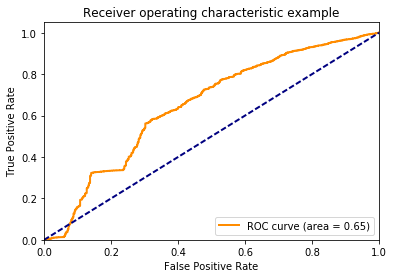

In [37]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from ggplot import *
import matplotlib.pyplot as plt

result = sm.GLM(train_Y, train_X[col_sig], family=sm.families.Binomial()).fit()
#print result.summary()

preds =  result.predict(validate_X[col_sig])
fpr, tpr, _ = metrics.roc_curve(validate_Y, preds)
auc = metrics.auc(tpr, fpr)

plt.figure()
lw = 2
plt.plot(tpr, fpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [38]:
threshold_list = [0.01, 0.1, 0.2, 0.5]
for t in range(0,len(threshold_list)):
#     del feature
    feature = validate[['visitorId','sentBookingRequest']]
    feature = feature.assign(preds = preds)
    thres = threshold_list[t]
    predictBookingRequest = feature.preds.apply(lambda x: 1 if x >= thres else 0)
    feature = feature.assign(predictBookingRequest = predictBookingRequest).assign(correctPredictionHeuristic = lambda x: x.sentBookingRequest == predictBookingRequest)

    accuracy = np.sum(feature.correctPredictionHeuristic)/float(len(feature.correctPredictionHeuristic))
    
    TP = len(feature.loc[(feature.sentBookingRequest == 1) & (feature.predictBookingRequest == 1),'sentBookingRequest'])
    TN = len(feature.loc[(feature.sentBookingRequest == 0) & (feature.predictBookingRequest == 0),'sentBookingRequest'])
    FP = len(feature.loc[(feature.sentBookingRequest == 0) & (feature.predictBookingRequest == 1),'sentBookingRequest'])
    FN = len(feature.loc[(feature.sentBookingRequest == 1) & (feature.predictBookingRequest == 0),'sentBookingRequest'])
    if ((TP + FP) > 0) & ((TP + FN) >0):
        precision = TP / float(TP + FP)
        recall = TP / float(TP + FN)
        f_score = 2*(precision*recall)/(precision + recall)
        print 'F_score is %.4f for Logistic Regression Model with threshold of %s' % (f_score,thres)
    else:
        print 'Unable to calculate precision and recall with threshold of %s' % (thres)
    print 'Accuracy is %s for Logistic Regression Model with threshold of %s' % (accuracy,thres)
    print 'Proportion of true "bookers" were you able to classify is %.4f with threshold of %s' % (recall,thres)
    print 'Proportion of true "lookers" were you able to classify is %.4f with threshold of %s' % (TN / float(TN + FP), thres)

F_score is 0.0467 for Logistic Regression Model with threshold of 0.01
Accuracy is 0.14075 for Logistic Regression Model with threshold of 0.01
Proportion of true "bookers" were you able to classify is 0.6947 with threshold of 0.01
Proportion of true "lookers" were you able to classify is 0.1234 with threshold of 0.01
F_score is 0.0400 for Logistic Regression Model with threshold of 0.1
Accuracy is 0.26885 for Logistic Regression Model with threshold of 0.1
Proportion of true "bookers" were you able to classify is 0.5033 with threshold of 0.1
Proportion of true "lookers" were you able to classify is 0.2615 with threshold of 0.1
F_score is 0.0387 for Logistic Regression Model with threshold of 0.2
Accuracy is 0.31635 for Logistic Regression Model with threshold of 0.2
Proportion of true "bookers" were you able to classify is 0.4538 with threshold of 0.2
Proportion of true "lookers" were you able to classify is 0.3121 with threshold of 0.2
F_score is 0.0800 for Logistic Regression Model 

## Problem 4 

This exercise will involve adding more complex model terms - interactions and polynomial terms. This will allow us to model nonlinear relationships as well as correctly take into account predictors that depend on each other.
a. Build the same logistic regression model as in (3c), but this time, include all 2-variable interactions. This will result in a much larger number of variables in your model. 

In [24]:
from sklearn.preprocessing import PolynomialFeatures
x_t = PolynomialFeatures(2).fit_transform(train_X[col_sig])

result_poly = sm.GLM(train_Y, x_t, family=sm.families.Binomial()).fit()
print result_poly.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:     sentBookingRequest   No. Observations:                60000
Model:                            GLM   Df Residuals:                    59940
Model Family:                Binomial   Df Model:                           59
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -6843.1
Date:                Sun, 23 Jul 2017   Deviance:                       13686.
Time:                        15:18:17   Pearson chi2:                 6.14e+04
No. Iterations:                    26                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -4.2645      0.042   -102.094      0.000        -4.346    -4.183
x1             0.0005   7.07e-05      6.937      0.0

In [27]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy 

formula = 'sentBookingRequest ~ I(timeOnSite**2) + I(numUniquePDPViews**2) + I(numPDPViews**2) +  I(numPDPFavorited**2) + I(numSearchesCompleted**2) + I(numUniqueDatedSearchesCompleted**2) + completedDatedSearch + enteredNumGuests + performedCustomSort + appliedAnyFilter + appliedPriceFilter + searchedInstantBook + inquired'
resesult_quadra = smf.glm(formula = formula,data=train, family=sm.families.Binomial()).fit() 
print(resesult_quadra.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     sentBookingRequest   No. Observations:                60000
Model:                            GLM   Df Residuals:                    59986
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -7031.9
Date:                Sun, 23 Jul 2017   Deviance:                       14064.
Time:                        15:18:53   Pearson chi2:                 5.86e+04
No. Iterations:                     9                                         
                                              coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -4.0521      0.034   -117.625 

In [28]:
x_t_val = PolynomialFeatures(2).fit_transform(validate_X[col_sig])

preds =  result_poly.predict(x_t_val)
fpr, tpr, _ = metrics.roc_curve(validate_Y, preds)
auc = metrics.auc(fpr,tpr)
print 'AUC for Model with 2-variable interactions is: %.4f' % auc

preds_quadra = resesult_quadra.predict(validate_X)
fpr, tpr, _ = metrics.roc_curve(validate_Y, preds_quadra)
auc = metrics.auc(fpr,tpr)
print 'AUC for Model with Quadratic terms is: %.4f' % auc

AUC for Model with 2-variable interactions is: 0.7626
AUC for Model with Quadratic terms is: 0.7657


## KNN 
Pick a k (somewhere between 1-50) and fit your model using the code below. Calculate the Area Under the ROC Curve (AUC).

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale

data_X = scale(train_X, with_mean=True)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(data_X, train_Y) 

data_X_vald = scale(validate_X[train_X.columns], with_mean=True)
data_Y_vald = neigh.predict(data_X_vald)
fpr, tpr, _ = metrics.roc_curve(validate_Y, data_Y_vald)
auc = metrics.auc(fpr,tpr)
print 'AUC for KNN model with k = %1.0f is: %.4f' % (3,auc)

AUC for KNN model with k = 3 is: 0.5460


In [30]:
k_list = [1, 5, 10, 25, 50, 75]
AUC_list = [0]*len(k_list)

for k in range(0,len(k_list)):
    k_val = k_list[k]
    neigh = KNeighborsClassifier(n_neighbors=k_val)
    neigh.fit(data_X, train_Y)
    data_Y_vald = neigh.predict(data_X_vald)
    fpr, tpr, _ = metrics.roc_curve(validate_Y, data_Y_vald)
    AUC_list[k] = metrics.auc(fpr,tpr)
    print 'AUC for KNN model with k = %1.0f is: %.4f' % (k_val,AUC_list[k])

AUC for KNN model with k = 1 is: 0.5531
AUC for KNN model with k = 5 is: 0.5386
AUC for KNN model with k = 10 is: 0.5262
AUC for KNN model with k = 25 is: 0.5269
AUC for KNN model with k = 50 is: 0.5176
AUC for KNN model with k = 75 is: 0.5159


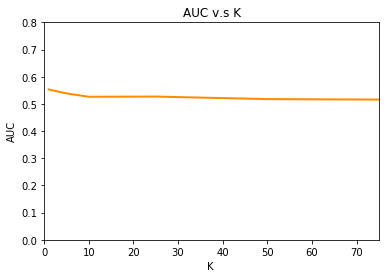

In [32]:
plt.figure()
lw = 2
plt.plot(k_list, AUC_list, color='darkorange',lw=lw)
plt.xlim([0.0, 75.0])
plt.ylim([0.0, 0.8])
plt.xlabel('K ')
plt.ylabel('AUC')
plt.title('AUC v.s K')
plt.show()

Pick your logistic regression model in (3c) and compare it to your best k-NN model. Now, we will finally use the test set to determine the best overall model. Calculate the Area Under the ROC Curve (AUC) of each model on the test set. Which model performs better?

In [34]:
test_X = test[col_sig]
test_Y = test['sentBookingRequest']
preds =  result.predict(test_X)
fpr, tpr, _ = metrics.roc_curve(test_Y, preds)
auc = metrics.auc(fpr,tpr)
print 'AUC for Logistic Regression model is: %.4f' % (AUC_list[k])

AUC for Logistic Regression model is: 0.5159


In [35]:
data_X_test = scale(test[train_X.columns], with_mean=True)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(data_X, train_Y) 
data_Y_test = neigh.predict(data_X_test)
fpr, tpr, _ = metrics.roc_curve(test_Y, data_Y_test)
auc = metrics.auc(fpr,tpr)
print 'AUC for KNN model with k = %1.0f is: %.4f' % (3,auc)

AUC for KNN model with k = 3 is: 0.5454
